In [2]:
import cv2
import os
import random
import numpy as np 
import matplotlib.pyplot as plt


In [3]:
import tensorflow as tf

2023-11-17 12:32:33.357290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [5]:
 # gestion du gpu
gpus =tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
# creation de dossiers d'images

#chemins
IMAGE_POS = os.path.join('data','positive')
IMAGE_NEG = os.path.join('data','negative')
SELFIE =  os.path.join('data','selfie')

# DOSSIERS

os.makedirs(IMAGE_POS)
os.makedirs(IMAGE_NEG)
os.makedirs(SELFIE)


In [8]:

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(IMAGE_NEG, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
# identifiant unique 
import uuid

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    frame_height, frame_width, _ = frame.shape
    roi_size = 250

    # Calcul des coordonnées pour centrer la ROI
    roi_y = (frame_height - roi_size) // 2
    roi_x = (frame_width - roi_size) // 2

    # Extraction de la ROI centrée
    frame = frame[roi_y:roi_y + roi_size, roi_x:roi_x + roi_size, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(SELFIE, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(IMAGE_POS, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [9]:
# augmentation du nombre d'images

def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [14]:
for file_name in os.listdir(os.path.join(SELFIE)):
    img_path = os.path.join(SELFIE, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
for image in augmented_images:
    cv2.imwrite(os.path.join(SELFIE, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [15]:
for file_name in os.listdir(os.path.join(IMAGE_POS)):
    img_path = os.path.join(IMAGE_POS, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(IMAGE_POS, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [16]:
# PREPROCESSING
selfie = tf.data.Dataset.list_files(SELFIE+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(IMAGE_POS+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(IMAGE_NEG+'\*.jpg').take(3000)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\positive\\*.jpg'

In [12]:
dir_test = selfie.as_numpy_iterator()

NameError: name 'selfie' is not defined

In [49]:
selfie.next()

b'data\\selfie\\a0bd4b2b-75bc-11ee-bb49-0cd292f992f9.jpg'

In [57]:
# RESCALE

def preprocess(file_path):
    
    
    byte_img = tf.io.read_file(file_path)
     
    img = tf.io.decode_jpeg(byte_img)
   
    img = tf.image.resize(img, (105,105))
    
    img = img / 255.0

    
    return img

In [58]:
img = preprocess('data\\selfie\\a0bd4b2b-75bc-11ee-bb49-0cd292f992f9.jpg')
img.numpy().max()

0.7481793

In [59]:
# CRETAION DES TRIPLETS 

positives = tf.data.Dataset.zip((selfie, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(selfie)))))
negatives = tf.data.Dataset.zip((selfie, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(selfie)))))
data = positives.concatenate(negatives)

In [ ]:
exemple = data.as_numpy_iterator()

In [ ]:
exemples =exemple.next()
print(exemples)

In [60]:


def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

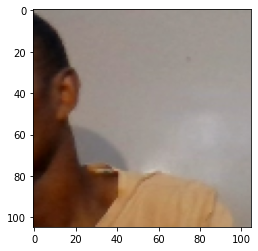

In [64]:
example = data.as_numpy_iterator()
exemple =example.next() 

res = preprocess_twin(*exemple)

plt.imshow(res[0])

In [65]:
#PIPELINE DE DONNEES

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [66]:

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
   
    if cv2.waitKey(10) & 0xFF == ord('v'):
        

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# LE MODELE 

In [68]:
inp = Input(shape=(105,105,3), name='input_image')

In [69]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [70]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [71]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [72]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [73]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [74]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [75]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [76]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
 
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [77]:
embedding = make_embedding()

In [78]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

# CALCUL DE DISTANCE

In [79]:

class L1Dist(Layer):
    
    
    def __init__(self, **kwargs):
        super().__init__()
       
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# iFace_Pass MODELE

In [82]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [83]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [84]:
siamese_layer = L1Dist()

In [85]:
distances = siamese_layer(inp_embedding, val_embedding)

In [86]:
classifier = Dense(1, activation='sigmoid')(distances)

In [87]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [88]:
iface_pass = Model(inputs=[input_image, validation_image], outputs=classifier, name='iFace_Pass')

In [89]:
iface_pass.summary()

Model: "iFace_Pass"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                         

In [90]:
def make_iface_pass_model(): 
    
    
    input_image = Input(name='input_img', shape=(105,105,3))
    
    
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
   
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='iFace_Pass')

In [93]:
iface_pass = make_iface_pass_model()

In [94]:
iface_pass.summary()

Model: "iFace_Pass"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                         

# ENTRAINEMENT

## OPTIMIZER-LOSS FUNCTION

In [95]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [96]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## ETABLIR UN CHECKPOINT

In [98]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=iface_pass)

## FONCTION D'ENTRAINEMENT

In [99]:
test_batch = train_data.as_numpy_iterator()

In [100]:
batch_1 = test_batch.next()

In [101]:
X = batch_1[:2]

In [102]:
y = batch_1[2]

In [103]:
y

array([1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [104]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = iface_pass(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
  
    grad = tape.gradient(loss, iface_pass.trainable_variables)
    
   
    opt.apply_gradients(zip(grad, iface_pass.trainable_variables))
        
    
    return loss

In [105]:

from tensorflow.keras.metrics import Precision, Recall

In [110]:
def train(data, EPOCHS):
   
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
         
        r = Recall()
        p = Precision()
        
        
        for idx, batch in enumerate(data):
            
            loss = train_step(batch)
            yhat = iface_pass.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
       
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# ENTRAINEMENT DU MODELE

In [111]:
EPOCHS = 50

In [112]:
train(train_data, EPOCHS)


 Epoch 1/50
18/31 [================>.............] - ETA: 7:53

KeyboardInterrupt: 